# Question 3

## A)

### Correlation matrix 

In [67]:
symbols=['A1','A2','A3']
corr_matrix = pd.DataFrame({'A1' : [1.0,0.5,0.2],
                                  'A2' : [0.5,1.0,-0.4],
                                  'A3' : [0.2,-0.4,1.0]
                                 })

corr_matrix=corr_matrix.set_index([['A1', 'A2','A3']])
print(corr_matrix)


initial_stock_price=[100,101,98]
mu=[0.03,0.06,0.02]
sigma=[0.05,0.2,0.15]


     A1   A2   A3
A1  1.0  0.5  0.2
A2  0.5  1.0 -0.4
A3  0.2 -0.4  1.0


### Cholesky Decomposition

In [68]:
from scipy.linalg import cholesky

upper_cholesky = cholesky(corr_matrix, lower=False)
print("Upper Matrix ")
print(upper_cholesky)

lower_cholesky = cholesky(corr_matrix, lower=True)
print("Lower Matrix ")
print(lower_cholesky)



Upper Matrix 
[[ 1.          0.5         0.2       ]
 [ 0.          0.8660254  -0.57735027]
 [ 0.          0.          0.79162281]]
Lower Matrix 
[[ 1.          0.          0.        ]
 [ 0.5         0.8660254   0.        ]
 [ 0.2        -0.57735027  0.79162281]]


## B)

In [69]:
import numpy as np 
from pandas import bdate_range  

num_assets = 3
dt = 1./365
num_steps=100
num_sim = 1000
dates = bdate_range(start=pd.to_datetime('today').date(), periods=num_steps)


###  Correlated Brownian Motion. 

In [70]:
np.random.seed(9999)
rand_val=np.random.standard_normal(size=(num_steps*num_sim,num_assets))
corr_values=rand_val.dot(upper_cholesky)*sigma
print (corr_values)


[[-0.02575197  0.05101558 -0.06102629]
 [-0.02442023 -0.1103201  -0.03043758]
 [ 0.09321305 -0.05112289  0.43905788]
 ..., 
 [-0.02128451 -0.08002611  0.20643784]
 [ 0.10634644  0.34986094  0.00389039]
 [-0.06591741 -0.05000563 -0.05746486]]


### 3-D Dataframe to store 3 stocks simulation prices

1st Dimension (X-axis) - Time step 

2nd Dimension (Y-axis) - Spot prices

3rd Dimension (Z-axis) - Different Assets

In [71]:
from pandas_datareader import data
from pandas import Panel, DataFrame

prices = Panel(items=symbols, minor_axis=range(num_sim), major_axis=dates)

initial_stock_price = np.array(initial_stock_price)

initial_stock_price= np.tile(initial_stock_price, num_sim)

initial_stock_price= initial_stock_price.reshape((3,1000), order='F')

prices.ix[:, 0, :] = initial_stock_price
prices.ix[:, 0, :].to_csv("testing.csv")

In [72]:
for i in range(1,num_steps):
    prices.ix[:, i, :] = prices.ix[:, i-1,:]*np.exp((mu-0.5*np.power(sigma,2))*dt + np.sqrt(dt)*corr_values[i::num_steps])  

print (prices.ix[:, -1, 1]) 
print (prices.ix[:, -1, 1].mean())

A1     99.816760
A2    105.535223
A3     92.627293
Name: 1, dtype: float64
99.3264255203696


### Plotting 

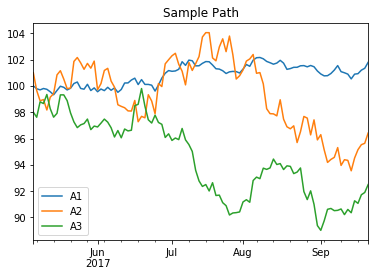

In [73]:
%matplotlib inline 
prices.ix[:, :, 666].plot(title='Sample Path', legend=True);

## C)

### Vanilla Basket

In [74]:
def Vanilla_Basket(optionType,K,num_sim,prices,printer=False):
    sum_value=0.0

    if optionType=="c":
        option=1
    else:
        option=-1
    for i in range(0,num_sim):
        sum_value=max(option*(prices.ix[:, -1, i].mean()-K),0)+sum_value
  
    valueOption=sum_value/num_sim
    
    if printer:
        if optionType=="c":
            print("Value of Vanilla Basket Call Option :: ", valueOption)
        
        else:
            print("Value of Vanilla Basket Put Option :: ", valueOption)
    
    return valueOption

Vanilla_Basket(optionType="c",K=100,num_sim=num_sim,prices=prices,printer=True)
Vanilla_Basket(optionType="p",K=100,num_sim=num_sim,prices=prices,printer=True)

Value of Vanilla Basket Call Option ::  1.9403923404126777
Value of Vanilla Basket Put Option ::  1.2426791138763966


1.2426791138763966

## D)

### 1) 
If the asset 2 (S2) hits the barrier B < S2(t) for some t then the payoff
of the option is equal to an European Call option written on the asset
2

In [75]:
def European_CallOption_Asset(optionType,K,num_sim,prices,assetNum,printer=False):
    sum_value=0.0
    assetID="A"+str(assetNum)
    if optionType=="c":
        option=1
    else:
        option=-1
    for i in range(0,num_sim):
        sum_value=max(option*(prices.ix[assetID, -1,i]-K),0)+sum_value

    
    valueOption=sum_value/num_sim
    if printer:    
        print ("Value of European_CallOption_Asset option on Asset " , assetID," :: ", valueOption)
    
    return valueOption

European_CallOption_Asset(optionType="c",K=100,num_sim=num_sim,prices=prices,assetNum=2,printer=True)

Value of European_CallOption_Asset option on Asset  A2  ::  5.67393553249


5.6739355324914991

### 2)

In [76]:
def European_Power_Option(optionType,K,num_sim,prices,assetNum,printer=False):
    sum_value=0.0
    assetID="A"+str(assetNum)
    if optionType=="c":
        option=1
    else:
        option=-1
    for i in range(0,num_sim):
        
        sum_value=np.power(max(option*(prices.ix[assetID, -1,i]-K),0),2)+sum_value

         
    valueOption=sum_value/num_sim
    if printer: 
        print ("Value of European_Power_Option option on Asset " , assetID," :: ", valueOption)
    return valueOption

European_Power_Option(optionType="c",K=100,num_sim=num_sim,prices=prices,assetNum=2,printer=True)

Value of European_Power_Option option on Asset  A2  ::  86.9940945605


86.99409456050364

### 3)

In [77]:
def European_Asian_Option(optionType,K,num_sim,prices,assetNum,printer=False):
    sum_value=0.0
    assetID="A"+str(assetNum)
    if optionType=="c":
        option=1
    else:
        option=-1
    for i in range(0,num_sim):
        averageStockPrice=prices.ix[assetID, :,i ].mean()
        #print prices.ix[i, -1, "A2"],powerStocPrice
        sum_value=max(option*(averageStockPrice-K),0)+sum_value
        
    valueOption=sum_value/num_sim
    if printer: 
        print ("Value of European_Asian_Option option on Asset " , assetID," :: ", valueOption)

    return valueOption
        
European_Asian_Option(optionType="c",K=100,num_sim=num_sim,prices=prices,assetNum=2,printer=True)

Value of European_Asian_Option option on Asset  A2  ::  3.550392244418431


3.550392244418431

### 4)

In [78]:
barrier=104
optionType="c"
strike=100


sum_value=0
for i in range(0,num_sim):
    if((prices.ix["A2", :, i]>barrier).any()):
        sum_value=sum_value+European_CallOption_Asset(optionType=optionType,K=strike,num_sim=num_sim,prices=prices,assetNum=2)
    elif( prices.ix["A2", :, i].max() > prices.ix["A3", :, i].max() ):
        sum_value=sum_value+European_Power_Option(optionType=optionType,K=strike,num_sim=num_sim,prices=prices,assetNum=2)
    elif( prices.ix["A2", :, i].mean() > prices.ix["A3", :, i].mean() ):
        sum_value=sum_value+European_Asian_Option(optionType=optionType,K=strike,num_sim=num_sim,prices=prices,assetNum=2)
    else:
        sum_value=sum_value+Vanilla_Basket(optionType=optionType,K=strike,num_sim=num_sim,prices=prices)

exoticOptionValue=sum_value/num_sim
print ("Value of Complex Exotic option :: ",exoticOptionValue)

Value of Complex Exotic option ::  9.9875351742
